In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/embeddings/fasttext-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','crossref/cermine/fasttext')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/crossref/cermine/fasttext', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [3]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/embeddings/fasttext-300.matrix.npy',
                        text_columns = ['author', 'title', 'journal'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True)

W0908 17:41:36.149971 10832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0908 17:41:36.359463 10832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0908 17:42:07.510932 10832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0908 17:42:08.097128 10832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0908 17:42:08.100092 10832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backen

Number of inputs to dense layer: 14


# Train model 

In [4]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

W0908 17:55:44.404623 10832 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0908 17:55:44.469101 10832 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1728716 samples, validate on 216089 samples
Epoch 1/10
1728716/1728716 [==============================] - 342s 198us/step - loss: 0.2310 - acc: 0.9257 - val_loss: 0.0559 - val_acc: 0.9902
Epoch 2/10
1728716/1728716 [==============================] - 264s 153us/step - loss: 0.0447 - acc: 0.9900 - val_loss: 0.0333 - val_acc: 0.9902
Epoch 3/10
1728716/1728716 [==============================] - 261s 151us/step - loss: 0.0281 - acc: 0.9900 - val_loss: 0.0229 - val_acc: 0.9902
Epoch 4/10
1728716/1728716 [==============================] - 263s 152us/step - loss: 0.0218 - acc: 0.9900 - val_loss: 0.0193 - val_acc: 0.9902
Epoch 5/10
1728716/1728716 [==============================] - 259s 150us/step - loss: 0.0176 - acc: 0.9937 - val_loss: 0.0143 - val_acc: 0.9963
Epoch 6/10
1728716/1728716 [==============================] - 255s 148us/step - loss: 0.0123 - acc: 0.9967 - val_loss: 0.0100 - val_acc: 0.9974
Epoch 7/10
1728716/1728716 [==============================] - 254s 147us/step - los

# Learning curves

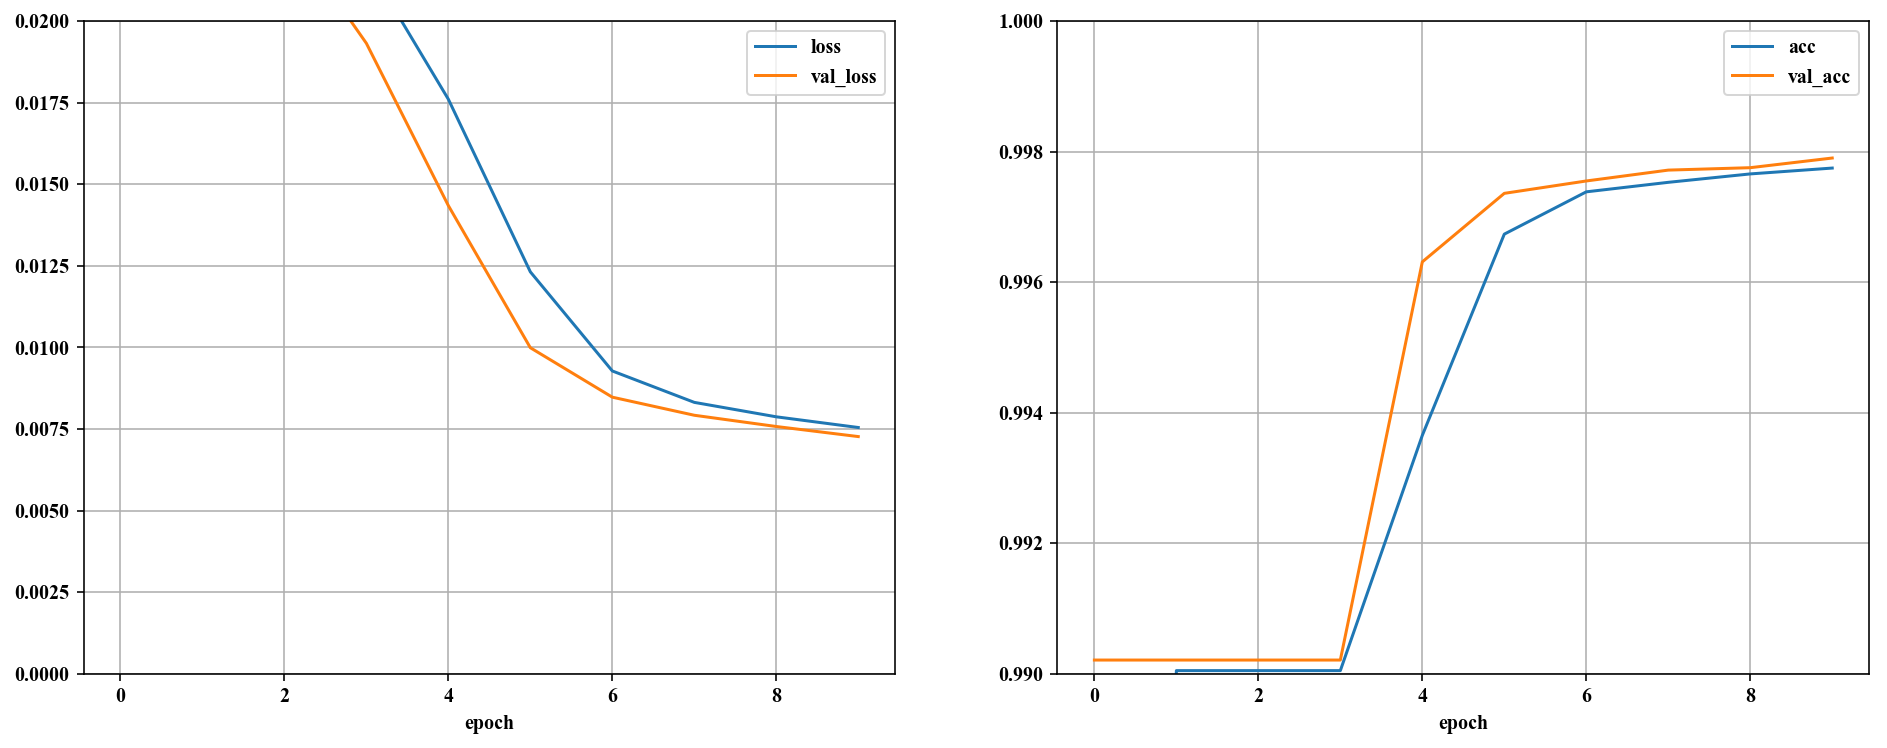

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.02)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [6]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    213973
           1       0.95      0.83      0.89      2116

   micro avg       1.00      1.00      1.00    216089
   macro avg       0.97      0.91      0.94    216089
weighted avg       1.00      1.00      1.00    216089

[[213882     91]
 [   362   1754]]


In [7]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['author', 'title', 'journal']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

,id1,author,title,journal,year,id2,author,title,journal,year
90599,2b6900b0-abdf-11e9-94b9-04ea56df376a,Colon Cancer Patient Information Seeking and the Adoption of Targeted Therapy for on-label and Off-Label Indications,"Gray , Crossref",<unk> Cancer 115.7,2009.0,2b699cc2-abdf-11e9-a108-04ea56df376a,Colon cancer patient information seeking and the adoption of targeted therapy for on-label and off-label indications,"Gray , S. W. , Armstrong , K. , DeMichele , A. , Schwartz , J. S. , Hornik , R. C.",Cancer,2009.0
212251,377e1de8-abdf-11e9-ba20-04ea56df376a,<unk>,<unk>,Communicative & Integrative Biology,2014.0,377d81d2-abdf-11e9-935e-04ea56df376a,"Catching synaptic vesicles in <unk> ( , 7 : 4 Communicative & Integrative Biology <unk>",<unk>,<unk>,2014.0
92052,32d58c00-abdf-11e9-85a9-04ea56df376a,26 : 6 Programming and,"Uvarov , D L.",<unk>,2000.0,32d499fe-abdf-11e9-90cb-04ea56df376a,<unk>,"Uvarov , D. L.","Programming and Computer Software , <unk>",2000.0
118157,4133c950-abdf-11e9-968a-04ea56df376a,History of the War in the Peninsula,NAPIER,<unk> <unk> <unk> <unk> / <unk>,0.0,41346562-abdf-11e9-8ec9-04ea56df376a,History of the War in the Peninsula and in the South of France,"<unk> , WFP",<unk>,0.0
114525,3c9d568c-abdf-11e9-9cf0-04ea56df376a,<unk>,<unk>,"<unk> 2 , <unk> <unk> <unk> 10",2016.0,3c9f2aae-abdf-11e9-9fbd-04ea56df376a,"<unk> volume 33 issue 2 Cover and Front <unk> ( , 33 : 2 British Catholic History f1",<unk>,<unk>,2016.0


# Save model and histories 

In [8]:
pd.DataFrame(histories).to_csv('../data/histories/crossref-cermine-fasttext.csv', index=False)
model.save_weights('../data/models/crossref-cermine-fasttext-base-1-num-null')

# Test model 

In [9]:
model.load_weights('../data/models/crossref-cermine-fasttext-base-1-num-null')
y_test_pred = model.predict(X_test, batch_size=8102)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

              precision    recall  f1-score   support

           0    0.99824   0.99951   0.99888    214019
           1    0.94216   0.81796   0.87568      2071

   micro avg    0.99777   0.99777   0.99777    216090
   macro avg    0.97020   0.90874   0.93728    216090
weighted avg    0.99770   0.99777   0.99770    216090

[[213915    104]
 [   377   1694]]
